In [1]:
# Imports and set torch device
import numpy as np
import meshplot as mp
import torch
import matplotlib.pyplot as plt
import kaolin as kal
import cv2
from collections import defaultdict

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print('Torch will run on:', device)

object = 'bookshelf' 
obj_path = 'data/demo/' + object + '.obj'

Torch will run on: cuda:0


In [2]:
# Read mesh
mesh = kal.io.obj.import_mesh(
    obj_path,
    with_normals=True,
    with_materials=False,
)

vertices_tensor = mesh.vertices.to(device)
faces_tensor = mesh.faces.to(device)

vertices = vertices_tensor.detach().cpu().numpy()
faces = faces_tensor.detach().cpu().numpy()
color =  mesh.vertex_normals.cpu().numpy()

print('Number of vertices: ', vertices.shape[0])
print('Number of faces: ', faces.shape[0])

Number of vertices:  5786
Number of faces:  8624


In [3]:
# Visualize mesh
mp.plot(vertices, faces, color)
plt.show()

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.4272670…

In [4]:
def get_camera_from_view2(elev, azim, r=3.0):
    x = r * torch.cos(elev) * torch.cos(azim)
    y = r * torch.sin(elev)
    z = r * torch.cos(elev) * torch.sin(azim)
    pos = torch.tensor([x, y, z]).unsqueeze(0)
    look_at = torch.mean(mesh.vertices, dim=0)-pos
    direction = torch.tensor([0.0, 1.0, 0.0]).unsqueeze(0)

    camera_proj = kal.render.camera.generate_transformation_matrix(pos, look_at, direction)
    return camera_proj


def render_view(elev, azim, r):
    background = torch.tensor([255.0, 255.0, 255.0]).to(device)
    # face_attributes = kal.ops.mesh.index_vertices_by_faces(
    #     torch.ones(1, len(mesh.vertices), 3).to(device)
    #     * torch.tensor([0.5, 0.5, 0.5]).unsqueeze(0).unsqueeze(0).to(device),
    #     faces_tensor,
    # )
    face_attributes = kal.ops.mesh.index_vertices_by_faces(
            mesh.vertex_normals.unsqueeze(0).to(device),
            faces_tensor
    ) 
    face_attributes = [
        face_attributes,  # Colors
        torch.ones((1, faces.shape[0], 3, 1), device=device),  # hard seg. mask
    ]
    
    camera_projection = kal.render.camera.generate_perspective_projection(np.pi / 3).to(
                    device
                )
    camera_transform = get_camera_from_view2(elev, azim, r=r).to(device)
    (
        face_vertices_camera,
        face_vertices_image,
        face_normals,
    ) = kal.render.mesh.prepare_vertices(
        mesh.vertices.to(device),
        mesh.faces.to(device),
        camera_projection,
        camera_transform=camera_transform,
    )

    image_features, soft_mask, face_idx = kal.render.mesh.dibr_rasterization(
        1024,
        1024,
        face_vertices_camera[:, :, :, -1],
        face_vertices_image,
        face_attributes,
        face_normals[:, :, -1],
    )
    image_features, mask = image_features
    image = torch.clamp(image_features, 0.0, 1.0)
    lights=torch.tensor([1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]).unsqueeze(0).to(device)
    image_normals = face_normals[:, face_idx].squeeze(0)
    image_lighting = kal.render.mesh.spherical_harmonic_lighting(
        image_normals, lights
        ).unsqueeze(0)
    image = image * image_lighting.repeat(1, 3, 1, 1).permute(
        0, 2, 3, 1
        ).to(device)
    image = torch.clamp(image, 0.0, 1.0)
    background_mask = torch.zeros(image.shape).to(device)
    mask = mask.squeeze(-1)
    background_idx = torch.where(mask == 0)
    assert torch.all(
        image[background_idx] == torch.zeros(3).to(device)
    )  # Remvoe it may be taking a lot of time
    background_mask[
        background_idx
    ] = background  # .repeat(background_idx[0].shape)
    image = torch.clamp(image + background_mask, 0.0, 1.0)
    image = image.squeeze().cpu().numpy()
    image *= 255.0
    image = image.astype(np.uint8)
    return image, face_idx

from SAM import SamPredictor, sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint="./SAM/MODEL/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


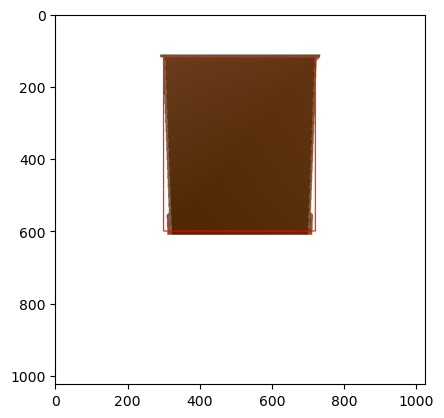

In [5]:
elev = torch.deg2rad(torch.tensor(15)).to(device)
azim = torch.deg2rad(torch.tensor(270)).to(device)
image, face_idx = render_view(elev, azim, 2)
face_idx = face_idx.squeeze()
img_to_show = image.copy()
startX = 300; startY = 120; endX = 720; endY = 600
cv2.rectangle(img_to_show, (startX, startY), (endX, endY), [255,0,0], 2)
plt.imshow(img_to_show)
plt.show()

In [6]:
# colors = np.random.rand(faces.shape[0], 3)
colors = np.zeros((faces.shape[0], 3))
included_faces_ids = defaultdict(int)
for col in range(startY, endY):
    for row in range(startX, endX):
        face_id = face_idx[row, col]
        if (face_id == -1):
            continue
        included_faces_ids[face_id] += 1
        colors[face_id] = np.array([1,0,0])
mp.plot(vertices, faces, colors)
plt.show()

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.4272670…